# Etude de cas data BCG ClientCo, Groupe 9

# Churn prediction use case
# Testing different Models



## Imports 

In [22]:
import math
import sklearn
import numpy as np
import pandas as pd
import datetime
from scipy import stats
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from functools import reduce
from matplotlib import pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
import graphviz 
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings("ignore")

# Creation of a complete DataSet

In [23]:
pd.set_option('display.max_rows', 50)
data_set = pd.read_csv('./customers_pre_2019.csv')
data_post = pd.read_csv('./customers_post_2019.csv')

# defining Labels : if Client bought in 2019 then he is labeled 0 (not churn) otherwise he is labeled 1 (churn)
clients_y = data_post.client_id.unique()
L = [(x in clients_y) for x in data_set.client_id.unique()]
data_set['churn'] = [abs(x*1-1) for x in L]

data_set['slope_delta_time'] = data_set['slope_delta_time']*data_set['r2_delta_time']
data_set['slope_sales'] = data_set['slope_sales']*data_set['r2_sales']

data_set.drop(['r2_sales','r2_delta_time','last_channel'],axis=1,inplace=True)

data_set.set_index('client_id',inplace=True)

X = data_set
X = X.loc[(X.Frequency > 6) ] # we keep only customers with enough data
X.dropna(inplace=True)

df_X = pd.DataFrame(X)

y = df_X['churn'] 
data_X = df_X.drop(['churn'],axis=1)

### Correlations

In [24]:
# Correlation as an indication for feature relevance
df_corr = df_X.corr()[['churn']]
df_corr['abs_churn'] = abs(df_corr.churn)
df_corr = df_corr.sort_values(by=['abs_churn'],ascending=False)[['churn']]
df_corr

,churn
churn,1.000000
Recency,0.571969
slope_sales,0.178475
Frequency,-0.120042
avg_last_3_delta,0.113205
std_delta_time,0.096092
last_delta_time,0.094157
total_revenue,-0.071348
q9,0.068340
avg_delta_time,0.066001


In [26]:
# We select the features
columns = ['Frequency','AOV','total_revenue','max_order','last_purchase','std_delta_time',
          'q9','slope_sales','slope_delta_time']
data_X = data_X[columns]


In [27]:
data_X.head(3)

,Frequency,AOV,total_revenue,max_order,last_purchase,std_delta_time,q9,slope_sales,slope_delta_time
client_id,,,,,,,,,
6,7,451.477729,3.160344e+03,1358.089878,98.8770,76.735042,157.5,5.096656e-03,-0.721056
14,1358,1452.360862,1.972306e+06,40529.598120,113.5740,0.763622,1.0,3.209852e-08,0.001581
18,306,454.009317,1.389269e+05,11578.098800,372.4068,2.371881,4.0,4.345515e-10,0.006866


# Model Tuning

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1)) # min max scaler
scoring = 'recall'
X = data_X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Undersampling of Train Set

In [28]:
df_train = pd.concat([X_train, y_train],axis=1)

# Class count
count_class_0, count_class_1 = df_train.churn.value_counts()

# Divide by class
df_class_0 = df_train[df_train['churn'] == 0]
df_class_1 = df_train[df_train['churn'] == 1]

repartition_rate = 1 # 
df_class_0_under = df_class_0.sample(count_class_1*repartition_rate)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.churn.value_counts())


Random under-sampling:
1    7991
0    7991
Name: churn, dtype: int64


In [29]:
df_test_under = df_test_under.sample(frac=1) # Schuffle DataFrame

In [30]:
X_train = df_test_under[columns]
y_train = df_test_under.churn

## Logistic Regression

In [14]:
pipeline =  Pipeline([('scaler', scaler),
                      ('logreg', LogisticRegression(max_iter=10000))])
param_grid = {'logreg__C': [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]}

kfold = StratifiedKFold(n_splits=5)
clf = GridSearchCV(pipeline, param_grid, cv=kfold, scoring=[scoring,'accuracy'],refit=scoring)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Résultats de la validation croisée :")
for mean,mean_accuracy, std, params in zip(clf.cv_results_['mean_test_'+str(scoring)],clf.cv_results_['mean_test_accuracy'], clf.cv_results_['std_test_'+str(scoring)], clf.cv_results_['params']):
    print("\n{} = {:.3f} (+/-{:.03f}) for {}".format(scoring, mean, std*2, params))
    print("{} = {:.3f}  ".format('accuracy', mean_accuracy))
    
print("\nBest params : {}".format(clf.best_params_)) 
print("Prediction recall = {:.3f}".format(recall_score(y_test, y_pred))) 
print("Prediction accuracy = {:.3f}".format(accuracy_score(y_test, y_pred)))

Résultats de la validation croisée :

recall = 0.466 (+/-0.040) for {'logreg__C': 0.01}
accuracy = 0.587  

recall = 0.479 (+/-0.068) for {'logreg__C': 0.1}
accuracy = 0.619  

recall = 0.582 (+/-0.109) for {'logreg__C': 1}
accuracy = 0.661  

recall = 0.722 (+/-0.021) for {'logreg__C': 10.0}
accuracy = 0.679  

recall = 0.741 (+/-0.016) for {'logreg__C': 100.0}
accuracy = 0.672  

recall = 0.743 (+/-0.020) for {'logreg__C': 1000.0}
accuracy = 0.669  

recall = 0.743 (+/-0.021) for {'logreg__C': 10000.0}
accuracy = 0.668  

Best params : {'logreg__C': 10000.0}
Prediction recall = 0.746
Prediction accuracy = 0.619


[[0.60254229 0.39745771]
 [0.25447244 0.74552756]]


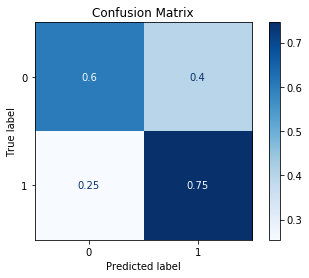

In [15]:
title = 'Confusion Matrix'
disp = plot_confusion_matrix(clf, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title(title)

print(disp.confusion_matrix)

## Decision Tree

In [16]:
pipeline =  Pipeline([
                      ('decision_tree', DecisionTreeClassifier())])
param_grid = {'decision_tree__max_depth': np.arange(1, 21)}

kfold = StratifiedKFold(n_splits=10)
clf = GridSearchCV(pipeline, param_grid, cv=kfold, scoring=[scoring,'accuracy'],refit=scoring)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Résultats de la validation croisée :")
for mean,mean_accuracy, std, params in zip(clf.cv_results_['mean_test_'+str(scoring)],clf.cv_results_['mean_test_accuracy'], clf.cv_results_['std_test_'+str(scoring)], clf.cv_results_['params']):
    print("\n{} = {:.3f} (+/-{:.03f}) for {}".format(scoring, mean, std*2, params))
    print("{} = {:.3f}  ".format('accuracy', mean_accuracy))

print("\nBest params : {}".format(clf.best_params_)) 
print("Prediction recall = {:.3f}".format(recall_score(y_test, y_pred))) 
print("Prediction accuracy = {:.3f}".format(accuracy_score(y_test, y_pred)))

Résultats de la validation croisée :

recall = 0.632 (+/-0.052) for {'decision_tree__max_depth': 1}
accuracy = 0.661  

recall = 0.632 (+/-0.052) for {'decision_tree__max_depth': 2}
accuracy = 0.661  

recall = 0.671 (+/-0.096) for {'decision_tree__max_depth': 3}
accuracy = 0.689  

recall = 0.734 (+/-0.085) for {'decision_tree__max_depth': 4}
accuracy = 0.704  

recall = 0.740 (+/-0.090) for {'decision_tree__max_depth': 5}
accuracy = 0.707  

recall = 0.724 (+/-0.049) for {'decision_tree__max_depth': 6}
accuracy = 0.721  

recall = 0.724 (+/-0.048) for {'decision_tree__max_depth': 7}
accuracy = 0.724  

recall = 0.730 (+/-0.037) for {'decision_tree__max_depth': 8}
accuracy = 0.723  

recall = 0.725 (+/-0.031) for {'decision_tree__max_depth': 9}
accuracy = 0.715  

recall = 0.717 (+/-0.046) for {'decision_tree__max_depth': 10}
accuracy = 0.713  

recall = 0.715 (+/-0.025) for {'decision_tree__max_depth': 11}
accuracy = 0.707  

recall = 0.706 (+/-0.020) for {'decision_tree__max_depth':

[[0.67786599 0.32213401]
 [0.25447244 0.74552756]]


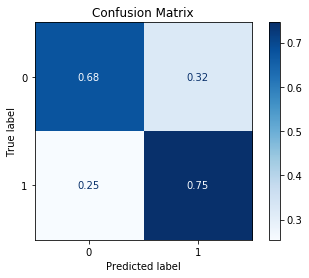

In [17]:
title = 'Confusion Matrix'
disp = plot_confusion_matrix(clf, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title(title)

print(disp.confusion_matrix)

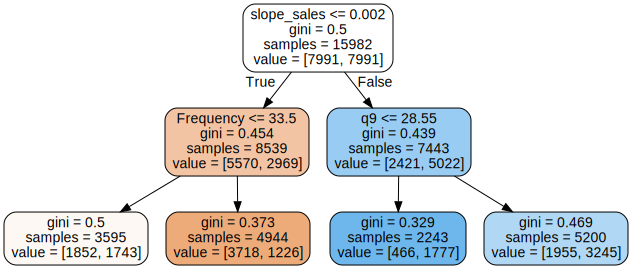

In [18]:
clf = DecisionTreeClassifier(max_depth = 2)
clf.fit(X_train, y_train)

dot_data = tree.export_graphviz(clf, out_file=None,
                               feature_names=X.columns,
                               filled=True, rounded=True,) 
graph = graphviz.Source(dot_data) 
graph

## Random Forest

In [19]:
pipeline =  Pipeline([('scaler', scaler),
                      
                      ('random_forest', RandomForestClassifier())])
param_grid = {'random_forest__max_depth': np.arange(5, 16, 5),
              'random_forest__n_estimators': np.arange(70, 201, 40)}

print("Entrée dans la CV")
kfold = StratifiedKFold(n_splits=3)
clf = GridSearchCV(pipeline, param_grid, cv=kfold, scoring=scoring)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Résultats de la validation croisée :")
for mean, std, params in tqdm(zip(clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score'], clf.cv_results_['params'])):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(scoring, mean, std*2, params))

print("\nBest params : {}".format(clf.best_params_)) 
print("Prediction recall = {:.3f}".format(recall_score(y_test, y_pred))) 
print("Prediction accuracy = {:.3f}".format(accuracy_score(y_test, y_pred)))

Entrée dans la CV
Résultats de la validation croisée :


recall = 0.739 (+/-0.027) for {'random_forest__max_depth': 5, 'random_forest__n_estimators': 70}
recall = 0.736 (+/-0.029) for {'random_forest__max_depth': 5, 'random_forest__n_estimators': 110}
recall = 0.742 (+/-0.023) for {'random_forest__max_depth': 5, 'random_forest__n_estimators': 150}
recall = 0.740 (+/-0.031) for {'random_forest__max_depth': 5, 'random_forest__n_estimators': 190}
recall = 0.750 (+/-0.015) for {'random_forest__max_depth': 10, 'random_forest__n_estimators': 70}
recall = 0.753 (+/-0.021) for {'random_forest__max_depth': 10, 'random_forest__n_estimators': 110}
recall = 0.751 (+/-0.022) for {'random_forest__max_depth': 10, 'random_forest__n_estimators': 150}
recall = 0.756 (+/-0.017) for {'random_forest__max_depth': 10, 'random_forest__n_estimators': 190}
recall = 0.760 (+/-0.019) for {'random_forest__max_depth': 15, 'random_forest__n_estimators': 70}
recall = 0.767 (+/-0.019) for {'random_forest__max_depth': 15, 'random_forest__n_estimators': 110}
recall = 0.767 (+

[[15405  5757]
 [  661  2078]]


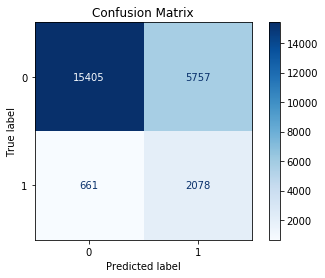

In [20]:

title = 'Confusion Matrix'
disp = plot_confusion_matrix(clf, X_test, y_test,
                             cmap=plt.cm.Blues)
disp.ax_.set_title(title)

print(disp.confusion_matrix)

[[0.72795577 0.27204423]
 [0.24132895 0.75867105]]


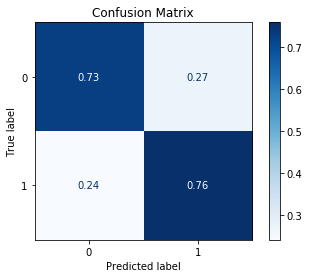

In [21]:
title = 'Confusion Matrix'
disp = plot_confusion_matrix(clf, X_test, y_test,
                             cmap=plt.cm.Blues, normalize = 'true')
disp.ax_.set_title(title)

print(disp.confusion_matrix)

# Ada boost

In [26]:
pipeline =  Pipeline([('scaler', scaler),
                      
                      ('adaboost', AdaBoostClassifier())])
param_grid = {
              'adaboost__n_estimators': np.arange(70, 201, 40)}

print("Entrée dans la CV")
kfold = StratifiedKFold(n_splits=3)
clf = GridSearchCV(pipeline, param_grid, cv=kfold, scoring=scoring)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Résultats de la validation croisée :")
for mean, std, params in tqdm(zip(clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score'], clf.cv_results_['params'])):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(scoring, mean, std*2, params))

print("\nBest params : {}".format(clf.best_params_)) 
print("Prediction recall = {:.3f}".format(recall_score(y_test, y_pred))) 
print("Prediction accuracy = {:.3f}".format(accuracy_score(y_test, y_pred)))

Entrée dans la CV
Résultats de la validation croisée :


recall = 0.815 (+/-0.022) for {'adaboost__n_estimators': 70}
recall = 0.817 (+/-0.016) for {'adaboost__n_estimators': 110}
recall = 0.814 (+/-0.016) for {'adaboost__n_estimators': 150}
recall = 0.815 (+/-0.018) for {'adaboost__n_estimators': 190}


Best params : {'adaboost__n_estimators': 110}
Prediction recall = 0.808
Prediction accuracy = 0.817


[[0.81783385 0.18216615]
 [0.19167579 0.80832421]]


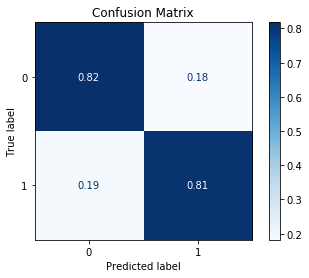

In [27]:

title = 'Confusion Matrix'
disp = plot_confusion_matrix(clf, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title(title)

print(disp.confusion_matrix)

# Gradient Boost

In [28]:
pipeline =  Pipeline([('scaler', scaler),
                      
                      ('XGB', GradientBoostingClassifier())])
param_grid = {
              'XGB__n_estimators': np.arange(70, 201, 40)}

print("Entrée dans la CV")
kfold = StratifiedKFold(n_splits=3)
clf = GridSearchCV(pipeline, param_grid, cv=kfold, scoring=scoring)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Résultats de la validation croisée :")
for mean, std, params in tqdm(zip(clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score'], clf.cv_results_['params'])):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(scoring, mean, std*2, params))

print("\nBest params : {}".format(clf.best_params_)) 
print("Prediction recall = {:.3f}".format(recall_score(y_test, y_pred))) 
print("Prediction accuracy = {:.3f}".format(accuracy_score(y_test, y_pred)))

Entrée dans la CV
Résultats de la validation croisée :


recall = 0.843 (+/-0.016) for {'XGB__n_estimators': 70}
recall = 0.842 (+/-0.019) for {'XGB__n_estimators': 110}
recall = 0.842 (+/-0.016) for {'XGB__n_estimators': 150}
recall = 0.840 (+/-0.016) for {'XGB__n_estimators': 190}


Best params : {'XGB__n_estimators': 70}
Prediction recall = 0.829
Prediction accuracy = 0.809


[[0.80583121 0.19416879]
 [0.17086528 0.82913472]]


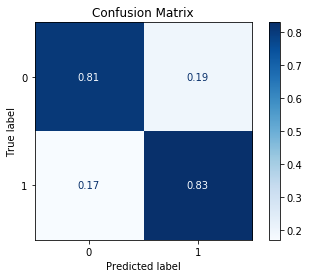

In [29]:

title = 'Confusion Matrix'
disp = plot_confusion_matrix(clf, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title(title)

print(disp.confusion_matrix)

# Bayes

In [30]:
clf = GaussianNB()
pipeline =  Pipeline([

('scaler_min_max', scaler),
('GNB', clf)])
pipeline.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Prediction recall = {:.3f}".format(recall_score(y_test, y_pred)))
print("Prediction accuracy = {:.3f}".format(accuracy_score(y_test, y_pred)))

Prediction recall = 0.019
Prediction accuracy = 0.885


[[0.99683395 0.00316605]
 [0.98064987 0.01935013]]


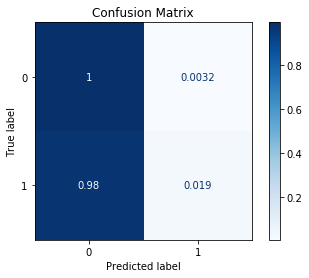

In [31]:

title = 'Confusion Matrix'
disp = plot_confusion_matrix(clf, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title(title)

print(disp.confusion_matrix)

On s'y attendait car l'hypothèse principale du modèle est l'indépendance des variables.
Ici les variables sont tout sauf indépendantes (PCA avec 1 composant rassemblait 99% de l'info)